In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
from tensorflow import keras

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

# Data Preprocessing

Data loading

In [2]:
token_path = "../data/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '../data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '../data/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '../data/Flickr8k_Dataset/'
glove_path = '../glove6b_model'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values

In [3]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

some basic text clean to get rid of punctuation and convert our descriptions to lowercase

In [4]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

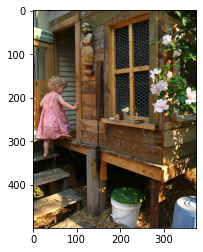

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [5]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set

In [6]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))


Original Vocabulary Size: 8828


 save the image id’s and their new cleaned captions in the same format as the token.txt file

In [7]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

 load all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file

In [8]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

all the training and testing images in train_img and test_img lists

In [9]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

load the descriptions of the training images into a dictionary

add two tokens in every caption, which are ‘startseq’ and ‘endseq’

In [10]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
            
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

Create a list of all the training captions

In [11]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus

In [12]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


store it in a file so that we can use it in another file as we have need this one for predicting caption .

In [13]:
with open('vocab.txt','w') as f:
    for x in vocab:
        f.write('%s\n'%x)

create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length

In [14]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

 max length of a caption

In [15]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


# Glove Embeddings

## map all the words in our 38-word long caption to a 300-dimension vector using Glove

In [20]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

make the matrix of shape (1660,300) consisting of our vocabulary and the 300-d vector

In [21]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building and Training

In [16]:
model_incv3 = keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)

model_rnv2 = keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)

we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the InceptionResNetV2 model and inceptionv3.

In [17]:
model_incv3_v1 = Model(model_incv3.input, model_incv3.layers[-2].output)
model_rnv2_v1 = Model(model_rnv2.input, model_rnv2.layers[-2].output)

we are using InceptionV3 we need to pre-process our input

preprocess function to reshape the images to (299 x 299)

 feed to the preprocess_input() function of Keras.

In [24]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [25]:
%%time

def encode(image,model):
    image = preprocess(image) 
    fea_vec = model.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

# with resetnetv2 model
encoding_train_rnv2 = {}
for img in train_img:
    encoding_train_rnv2[img[len(images_path):]] = encode(img,model_rnv2_v1)
train_features = encoding_train_rnv2

encoding_test_rnv2 = {}
for img in test_img:
    encoding_test_rnv2[img[len(images_path):]] = encode(img,model_rnv2_v1)
    
# with inceptionv3 model
encoding_train_incv3 = {}
for img in train_img:
    encoding_train_incv3[img[len(images_path):]] = encode(img,model_incv3_v1)
train_features = encoding_train_rnv2

encoding_test_incv3 = {}
for img in test_img:
    encoding_test_incv3[img[len(images_path):]] = encode(img,model_incv3_v1)

Wall time: 38min 3s


let’s define our model.

We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:


Processing the sequence from the text 

Extracting the feature vector from the image

Decoding the output using softmax by concatenating the above two layers

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 300)      498000      input_8[0][0]                    
____________________________________________________________________________________________

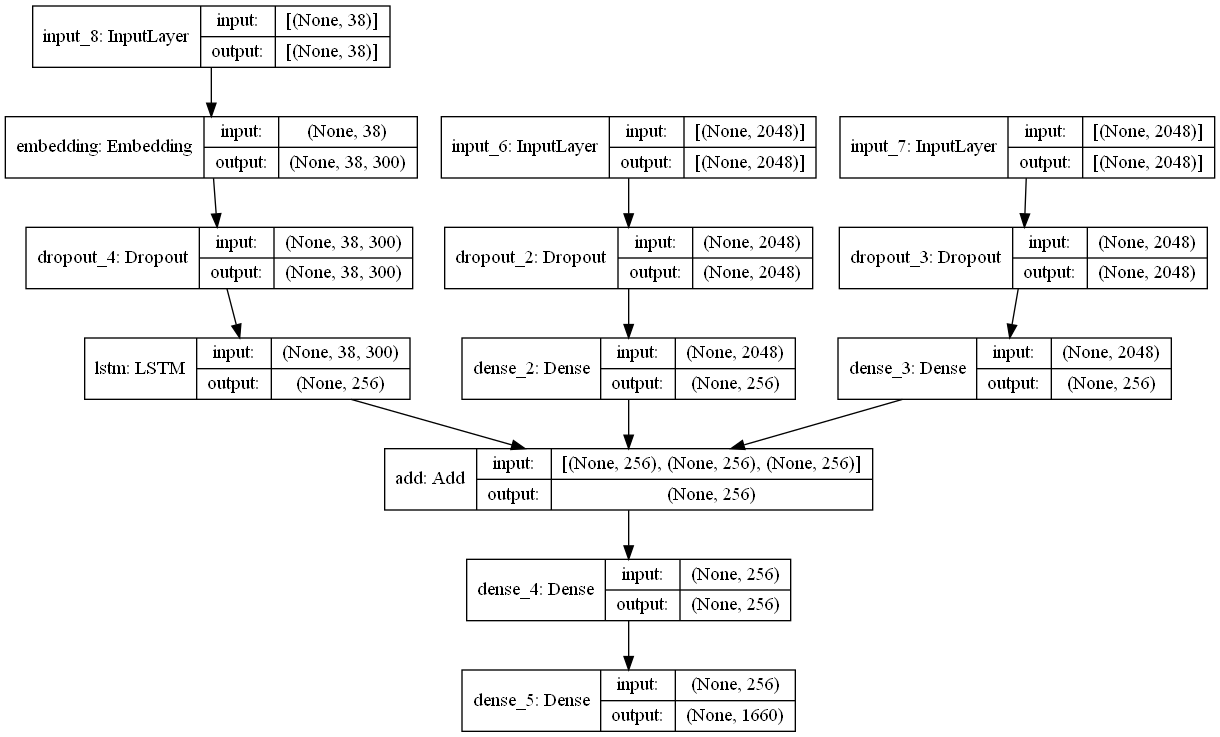

In [22]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(2048,))
ge1 = Dropout(0.5)(inputs2)
ge2 = Dense(256, activation='relu')(ge1)

inputs3 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs3)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, ge2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
model.summary()
keras.utils.plot_model(model, show_shapes=True, to_file='inception_resnet_lstm model.png')   # if you facing issue here just go to info.txt

#  Model Training

## not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [26]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.

In [28]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [29]:
%%time

epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 316s 157ms/step - loss: 3.6923
Epoch 2/30
2000/2000 [==============================] - 322s 161ms/step - loss: 3.0311
Epoch 3/30
2000/2000 [==============================] - 324s 162ms/step - loss: 2.8331
Epoch 4/30
2000/2000 [==============================] - 323s 161ms/step - loss: 2.7134
Epoch 5/30
2000/2000 [==============================] - 323s 161ms/step - loss: 2.6279
Epoch 6/30
2000/2000 [==============================] - 323s 162ms/step - loss: 2.5624
Epoch 7/30
2000/2000 [==============================] - 321s 160ms/step - loss: 2.5096
Epoch 8/30
2000/2000 [==============================] - 312s 156ms/step - loss: 2.4679
Epoch 9/30
2000/2000 [==============================] - 313s 156ms/step - loss: 2.4336
Epoch 10/30
2000/2000 [==============================] - 324s 162ms/step - loss: 2.4030
Epoch 11/30
2000/2000 [==============================] - 315s 157ms/step - loss: 2.3767
Epoch 12/30
2000/2000 [==================

In [30]:
model.save('expresso_model.h5')

Saving the model as signlang_model.h5


C:\Users\suraj\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Greedy and Beam Search

## model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search

In [41]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [32]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Testing on random image

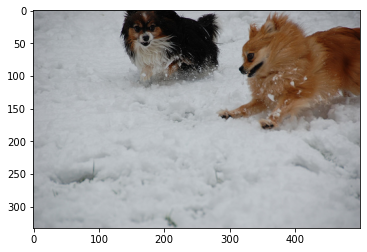

[1]
[1, 2]
[1, 2, 26]
[1, 2, 26, 7]
[1, 2, 26, 7, 106]
[1, 2, 26, 7, 106, 111]
[1, 2, 26, 7, 106, 111, 22]
[1, 2, 26, 7, 106, 111, 22, 160]
Greedy Search: a dog is running through the snow
Beam Search, K = 3: two dogs play in the snow
Beam Search, K = 5: a black and white dog running through the snow
Beam Search, K = 7: a brown and white dog runs through the snow
Beam Search, K = 10: a brown and white dog runs through the snow


In [42]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))